In [1]:
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ccai9012 import nn_utils, viz_utils

## Step 1: Fetch dataset and prepare for model training (same process as week 2)

In [3]:
# Fetch the California housing dataset
california = fetch_california_housing()
X_california = california.data
y_california = california.target
feature_names = california.feature_names

# Normarlize data and prepare dataloaders
train_loader, val_loader, test_loader, scaler = nn_utils.prepare_dataloaders(
    X_california,
    y_california,
    batch_size=64,
    train_ratio=0.8,
    val_ratio=0.1
)

## Step 2: Define and train the model (a simple MLP)

In [4]:
# Model Build: Two-layer MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # regression output

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_dim = X_california.shape[1]  # 8 features
hidden_dim = 64  # can tune this

# Initialize the model
device = nn_utils.get_best_device()
model = SimpleMLP(input_dim, hidden_dim).to(device)

In [5]:
# Training Setup
learning_rate = 0.001  # step size for optimizer
num_epochs = 50        # number of passes over entire dataset
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = nn_utils.train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs
)

Epoch [1/50] - Train Loss: 1.8761, Val Loss: 0.6805
Epoch [2/50] - Train Loss: 0.6230, Val Loss: 0.5231
Epoch [3/50] - Train Loss: 0.4941, Val Loss: 0.4341
Epoch [4/50] - Train Loss: 0.4393, Val Loss: 0.3883
Epoch [5/50] - Train Loss: 0.4169, Val Loss: 0.3740
Epoch [6/50] - Train Loss: 0.4032, Val Loss: 0.3718
Epoch [7/50] - Train Loss: 0.3937, Val Loss: 0.3827
Epoch [8/50] - Train Loss: 0.3849, Val Loss: 0.3756
Epoch [9/50] - Train Loss: 0.3827, Val Loss: 0.3628
Epoch [10/50] - Train Loss: 0.3721, Val Loss: 0.3944
Epoch [11/50] - Train Loss: 0.3651, Val Loss: 0.3290
Epoch [12/50] - Train Loss: 0.3596, Val Loss: 0.3902
Epoch [13/50] - Train Loss: 0.3576, Val Loss: 0.3450
Epoch [14/50] - Train Loss: 0.3525, Val Loss: 0.3209
Epoch [15/50] - Train Loss: 0.3500, Val Loss: 0.3640
Epoch [16/50] - Train Loss: 0.3461, Val Loss: 0.3135
Epoch [17/50] - Train Loss: 0.3430, Val Loss: 0.3091
Epoch [18/50] - Train Loss: 0.3400, Val Loss: 0.4878
Epoch [19/50] - Train Loss: 0.3374, Val Loss: 0.3698
Ep

## Step 3: GLobal explanation with SHAP

In [6]:
# train_loader.dataset is a Subset object; .dataset points to the original TensorDataset
full_dataset = train_loader.dataset.dataset

# tensors[0] contains features, tensors[1] contains labels
X_tensor = full_dataset.tensors[0].to(device)
y_tensor = full_dataset.tensors[1].to(device)

print("X_tensor shape:", X_tensor.shape)
print("y_tensor shape:", y_tensor.shape)

X_tensor shape: torch.Size([20640, 8])
y_tensor shape: torch.Size([20640, 1])


In [7]:
# Define SHAP explainer with background data
background = X_tensor[:100]  # background for SHAP, the average prediction of the samples as baseline

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

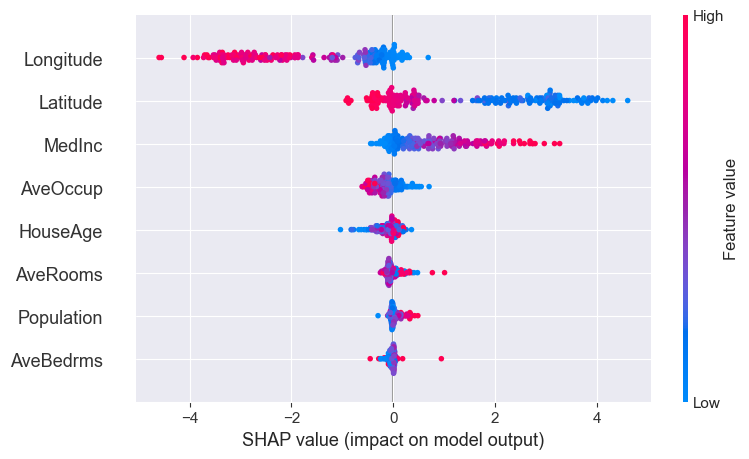

In [8]:
# Randomly sample 200 examples from X_tensor
n_global = 200
idx = np.random.choice(X_tensor.shape[0], n_global, replace=False)
X_global = X_tensor[idx]

# Compute SHAP values
shap_values_global = explainer.shap_values(X_global).squeeze(-1)

# Convert back to numpy for SHAP plots
X_global_np = X_global.cpu().numpy()

# SHAP summary plot (global explanation)
shap.summary_plot(shap_values_global, X_global_np, feature_names=california.feature_names)

**Spatial location** (lat,lon) shows significant impact on housing price, we will then visualize the housing price distribution on the map for validation.

In [9]:
import pandas as pd

# Prepare data in DataFrame
df = pd.DataFrame({
    'latitude': X_california[:, california.feature_names.index('Latitude')],
    'longitude': X_california[:, california.feature_names.index('Longitude')],
    'price': y_california.flatten()
})

m = viz_utils.plot_heatmap(df, target_col='price')
m

/Users/kanxuanhe/Document/250421_AI_course/toolkit/ccai9012/viz_utils.py:342: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(


**The coastal area of Los Angeles** is a prominent high-price region in California, corresponding to a relatively low latitude. 
The importance of factors affecting housing prices varies across different cities; therefore, a more reasonable approach might be to **split the data by city and perform global explanation accordingly**.

## Step 4: Global explanation within sub-dataset of selected cities

In [18]:
# Define approximate latitude and longitude ranges for selected CA cities
city_bounds = {
    'Los Angeles':   {'lat_min': 33.7, 'lat_max': 34.4, 'lon_min': -118.7, 'lon_max': -118.0},
    'San Francisco': {'lat_min': 37.6, 'lat_max': 37.9, 'lon_min': -123.0, 'lon_max': -122.3},
    'Sacramento':    {'lat_min': 38.4, 'lat_max': 38.7, 'lon_min': -121.7, 'lon_max': -121.3},
    'Fresno':        {'lat_min': 36.7, 'lat_max': 36.9, 'lon_min': -120.0, 'lon_max': -119.6},
    'Bakersfield':   {'lat_min': 35.3, 'lat_max': 35.5, 'lon_min': -119.1, 'lon_max': -118.8},
}

# Extract latitude and longitude columns by feature names
lat_idx = feature_names.index('Latitude')
lon_idx = feature_names.index('Longitude')

latitudes = X_california[:, lat_idx]
longitudes = X_california[:, lon_idx]

# Function to get indices of samples within the given city's lat/lon bounds
def filter_city_indices(city_name):
    bounds = city_bounds[city_name]
    idx = np.where(
        (latitudes >= bounds['lat_min']) & (latitudes <= bounds['lat_max']) &
        (longitudes >= bounds['lon_min']) & (longitudes <= bounds['lon_max'])
    )[0]
    return idx

# Example: get indices for Los Angeles samples
for city in city_bounds:
    indices = filter_city_indices(city)
    print(f"Number of samples in {city}: {len(indices)}")

Number of samples in Los Angeles: 5410
Number of samples in San Francisco: 763
Number of samples in Sacramento: 568
Number of samples in Fresno: 350
Number of samples in Bakersfield: 206


SHAP summary plot for Los Angeles (100 samples)


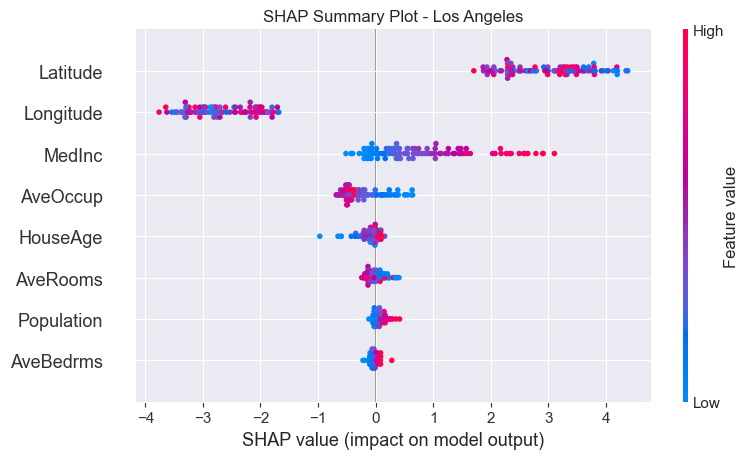

SHAP summary plot for San Francisco (100 samples)


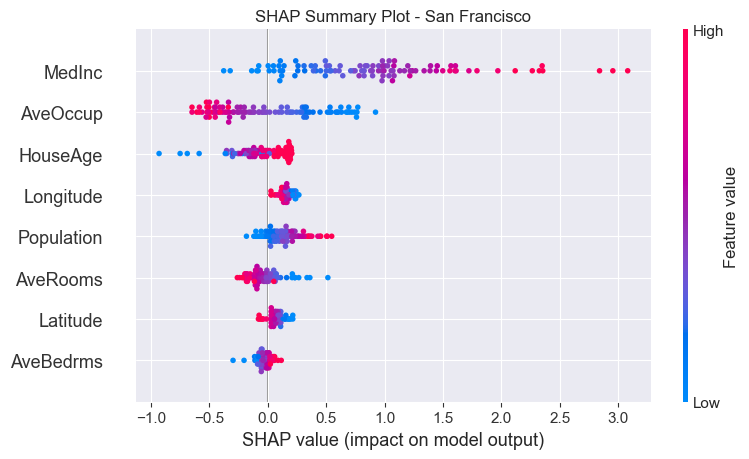

SHAP summary plot for Sacramento (100 samples)


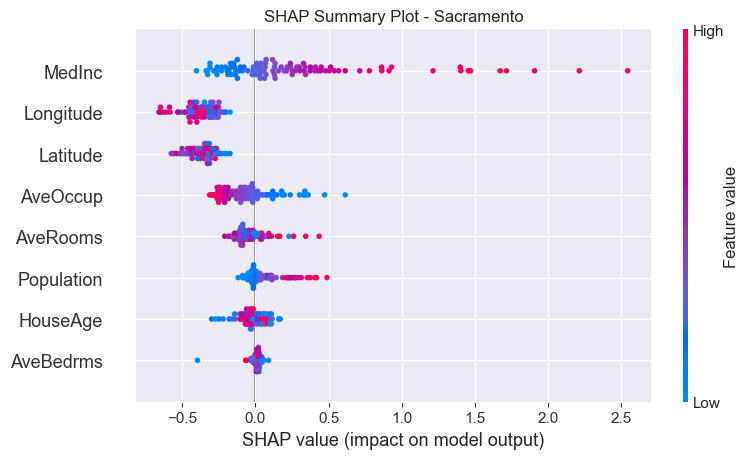

SHAP summary plot for Fresno (100 samples)


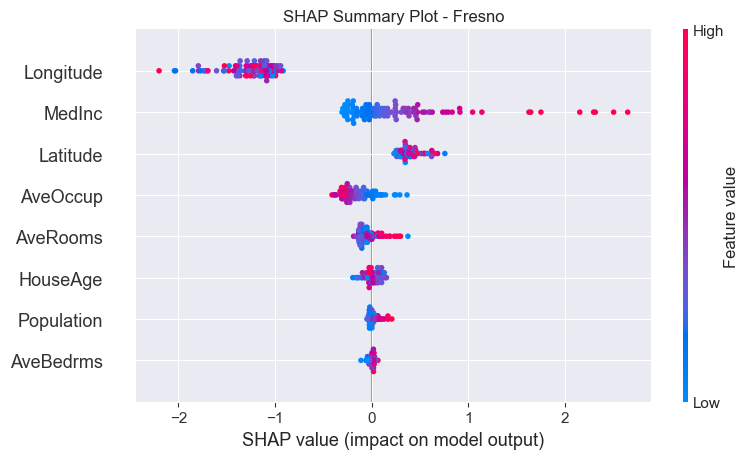

SHAP summary plot for Bakersfield (100 samples)


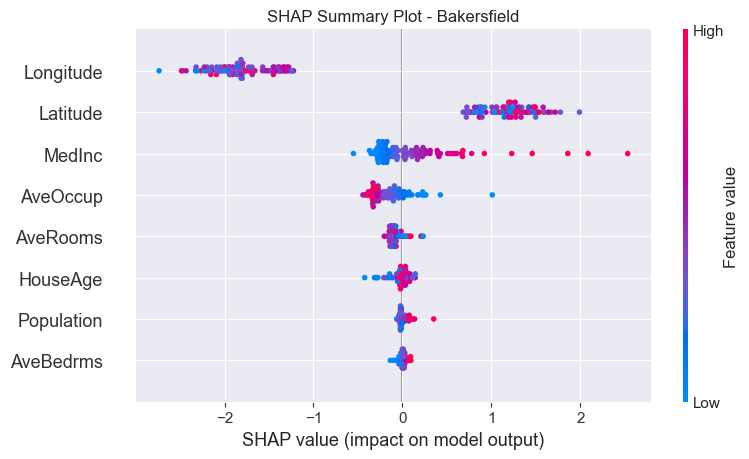

In [19]:
# Number of samples to randomly select from each city for SHAP analysis
n_samples_per_city = 100

city_samples = {}
for city in city_bounds:
    indices = filter_city_indices(city)
    if len(indices) == 0:
        print(f"No data for {city}, skipping...")
        continue
    # Randomly sample (without replacement) up to n_samples_per_city from this city
    sample_size = min(len(indices), n_samples_per_city)
    sampled_idx = np.random.choice(indices, sample_size, replace=False)
    city_samples[city] = sampled_idx

# Now compute SHAP values for each city's samples
shap_values_city = {}
for city, sample_indices in city_samples.items():
    X_city_sample = X_tensor[sample_indices]
    # Use the same explainer, background, and model as before
    shap_values = explainer.shap_values(X_city_sample).squeeze(-1)  # shape (sample_size, n_features)
    shap_values_city[city] = (shap_values, X_city_sample.cpu().numpy())

# Plot SHAP summary plots for all cities with available SHAP values
for city, (shap_vals, X_samples_np) in shap_values_city.items():
    print(f"SHAP summary plot for {city} ({shap_vals.shape[0]} samples)")
    plt.title(f"SHAP Summary Plot - {city}")
    shap.summary_plot(
        shap_vals,
        X_samples_np,
        feature_names=california.feature_names,
        show=True
    )

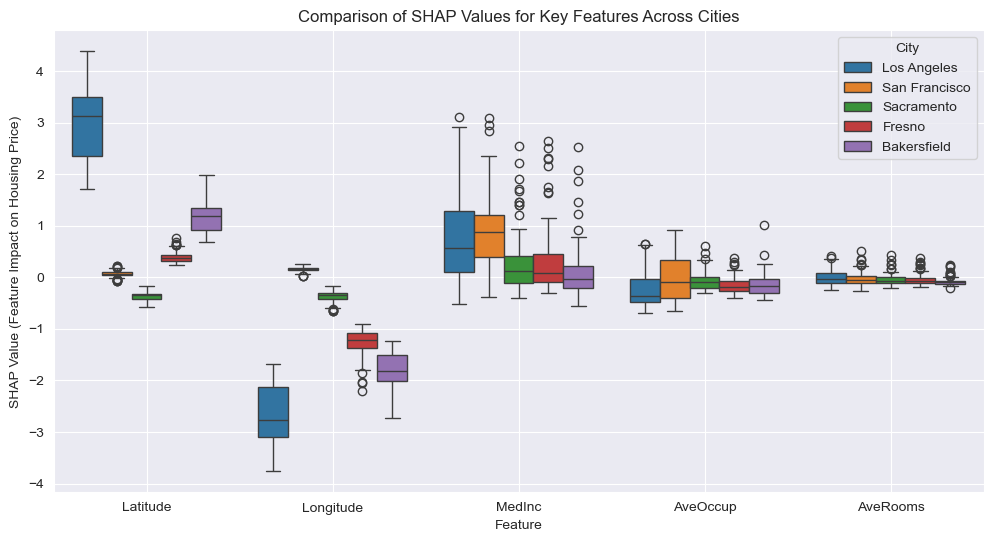

In [20]:
import seaborn as sns

# Select a few important features to compare
features_to_compare = ['Latitude', 'Longitude', 'MedInc', 'AveOccup', 'AveRooms']  
feature_indices = [california.feature_names.index(f) for f in features_to_compare]

# Prepare data for plotting
data_list = []

for city, (shap_vals, _) in shap_values_city.items():
    for i, feat_idx in enumerate(feature_indices):
        # Extract SHAP values for the feature in this city
        vals = shap_vals[:, feat_idx]
        for val in vals:
            data_list.append({
                'City': city,
                'Feature': features_to_compare[i],
                'SHAP Value': val
            })

df = pd.DataFrame(data_list)

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Feature', y='SHAP Value', hue='City')
plt.title('Comparison of SHAP Values for Key Features Across Cities')
plt.ylabel('SHAP Value (Feature Impact on Housing Price)')

plt.grid(True)
plt.show()

1. **Geographical factors (latitude and longitude)** have overall the most significant impact, especially in Los Angeles and Bakersfield.
2. **Median income (MedInc)** is a generally important factor across regions after that, but its influence is stronger in major cities (Los Angeles, San Fransisco) and relatively less significant in smaller cities.

## Step 5: Local explanation

While global explanations help understand overall feature importance across the dataset, they may be misleading in cases involving **outliers or atypical samples**. In such cases, **local explanations** can reveal the actual driving forces behind individual prediction and avoid potential bias.

Selected outlier sample index in SF: 9386, house price: 5.00001


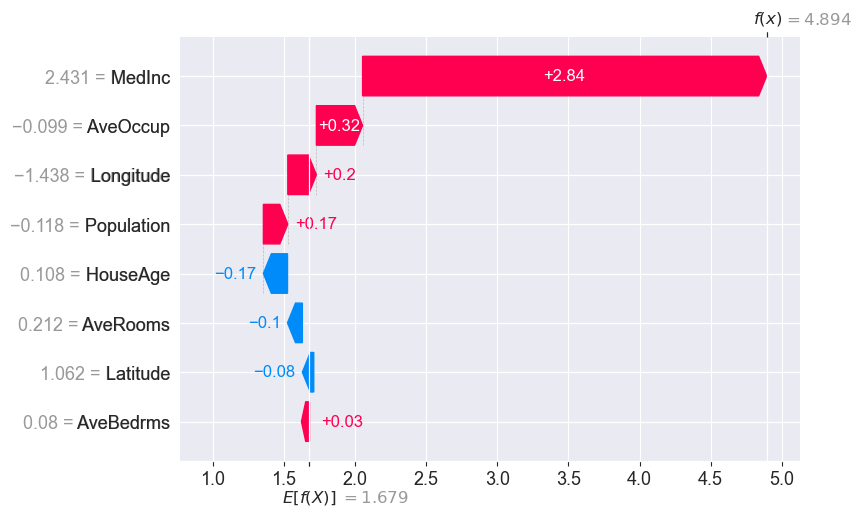

In [22]:
# Step 1: Get indices of all samples within Los Angeles city bounds
sf_indices = city_samples['San Francisco']

# Step 2: Extract true house prices for these SF samples
y_sf = y_california[sf_indices]

# Step 3: Find the sample with the highest house price in SF (outlier)
outlier_idx_sf = np.argmax(y_sf)  # index within la_indices array
outlier_global_idx = sf_indices[outlier_idx_sf]  # index relative to whole dataset

print(f"Selected outlier sample index in SF: {outlier_global_idx}, house price: {y_california[outlier_global_idx]}")

# Step 4: Extract the input features of this outlier sample as a tensor with batch dim
X_outlier = X_tensor[outlier_global_idx].unsqueeze(0)  # shape (1, n_features)

# Step 5: Compute SHAP values for this single outlier sample
shap_values_outlier = explainer.shap_values(X_outlier).squeeze(-1)  # shape (1, n_features) -> (n_features,)

# Step 6: Plot local explanation (waterfall plot) for this outlier sample
expl = shap.Explanation(
    values=shap_values_outlier[0],          
    base_values=explainer.expected_value,  
    data=X_outlier.cpu().numpy()[0],        
    feature_names=california.feature_names
)

shap.plots.waterfall(expl)